<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/02_cnn_structure_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 구조 변경 (kernel size, pooling 여부)

### 🧪 실험 목표

목표: CIFAR-10 분류 정확도를 높이기 위해 CNN 구조를 변경하여 성능을 비교합니다.

변경 항목:

커널 크기 (예: 3x3 → 5x5)

풀링 여부 (MaxPooling 적용/미적용)

레이어 개수 (Conv 레이어 수 증가)

In [1]:
# =======================
# 1) 라이브러리 불러오기
# =======================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# =======================
# 2) 데이터셋 & 전처리
# =======================
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


1. Train: 데이터 증강 적용 (좌우 뒤집기, 랜덤 Crop) → 일반화 성능 향상
2. Test: 원본 데이터를 정규화만 적용
3. CIFAR-10 데이터셋 로드
4. DataLoader를 이용해 미니배치 학습 가능

In [3]:
# =======================
# 3) CNN 모델 정의 (세 가지 실험)
# =======================
class BasicCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8,512)
        self.fc2 = nn.Linear(512,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class LargerKernelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,5,padding=2)   # kernel 5x5
        self.conv2 = nn.Conv2d(32,64,5,padding=2)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*8*8,512)
        self.fc2 = nn.Linear(512,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,64*8*8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class NoPoolingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.fc1 = nn.Linear(64*32*32,512)
        self.fc2 = nn.Linear(512,10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,64*32*32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class DeeperCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.conv3 = nn.Conv2d(64,128,3,padding=1)  # 추가 레이어
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*4*4,512)
        self.fc2 = nn.Linear(512,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,128*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

- BasicCNN: 기본 구조, kernel 3×3, pooling 적용
- LargerKernelCNN: kernel 5×5, pooling 적용
- NoPoolingCNN: pooling 제거, feature map 유지
- DeeperCNN: Conv 레이어 수 3개, pooling 적용

1. forward()에서 Conv → ReLU → Pooling 순으로 처리
2. 마지막 시점 feature map을 flatten 후 FC layer로 클래스 예측

In [4]:
# =======================
# 4) 모델 리스트 정의
# =======================

# 1. 모델 리스트 정의

model_list = [
    ("BasicCNN", BasicCNN()),
    ("LargerKernelCNN", LargerKernelCNN()),
    ("NoPoolingCNN", NoPoolingCNN()),
    ("DeeperCNN", DeeperCNN())
]

results = {}

1. 실험할 CNN 모델과 이름을 튜플로 묶어서 리스트에 저장
2. results 딕셔너리는 각 모델의 테스트 정확도를 저장할 공간

In [5]:
# =======================
# 5) 모델별 학습 및 테스트
# =======================
for name, model in model_list:
    print(f"\n=== Training {name} ===")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 학습
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"[Epoch {epoch+1}] loss: {running_loss/len(trainloader):.3f}")

    # 테스트 정확도
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    results[name] = acc
    print(f"Accuracy of {name} on test images: {acc:.2f}%")


=== Training BasicCNN ===
[Epoch 1] loss: 1.480
[Epoch 2] loss: 1.148
[Epoch 3] loss: 1.011
[Epoch 4] loss: 0.924
[Epoch 5] loss: 0.864
[Epoch 6] loss: 0.814
[Epoch 7] loss: 0.775
[Epoch 8] loss: 0.740
[Epoch 9] loss: 0.716
[Epoch 10] loss: 0.692
Accuracy of BasicCNN on test images: 76.36%

=== Training LargerKernelCNN ===
[Epoch 1] loss: 1.568
[Epoch 2] loss: 1.241
[Epoch 3] loss: 1.090
[Epoch 4] loss: 0.991
[Epoch 5] loss: 0.933
[Epoch 6] loss: 0.881
[Epoch 7] loss: 0.838
[Epoch 8] loss: 0.805
[Epoch 9] loss: 0.789
[Epoch 10] loss: 0.761
Accuracy of LargerKernelCNN on test images: 74.06%

=== Training NoPoolingCNN ===
[Epoch 1] loss: 1.631
[Epoch 2] loss: 1.249
[Epoch 3] loss: 1.086
[Epoch 4] loss: 1.001
[Epoch 5] loss: 0.943
[Epoch 6] loss: 0.897
[Epoch 7] loss: 0.861
[Epoch 8] loss: 0.834
[Epoch 9] loss: 0.813
[Epoch 10] loss: 0.789
Accuracy of NoPoolingCNN on test images: 72.20%

=== Training DeeperCNN ===
[Epoch 1] loss: 1.518
[Epoch 2] loss: 1.136
[Epoch 3] loss: 0.950
[Epoch 4

1. 리스트에서 하나씩 모델을 꺼내 학습 시작
2. GPU가 있으면 device로 이동
3. 손실함수: CrossEntropy -> 분류 문제에 적합
4. 옵티마이저: Adam -> 학습률 자동 조정 및 빠른 수렴
5. 학습 루프
- 1. Epoch 수만큼 전체 데이터 반복
- 2. 미니배치 단위 학습: inputs, labels
- 3. optimizer.zero_grad() -> 이전 gradient 초기화
- 4. loss.backward() -> gradient 계산 (역전파)
- 5. optimizer.step() -> 가중치 업데이트
- 6. Epoch 평균 손실 출력 -> 학습 상태 확인
6. 테스트 평가
- 1. torch.no_grad() -> gradient 계산X -> 메모리 절약
- 2. torch.max(outputs.data, 1) -> 예측 클래스 선택
- 3. 맞춘 개수 / 총 개수 -> 정확도 계산
- 4. results 딕셔너리에 저장 -> 나중에 비교 가능

In [6]:
# =======================
# 6) 결과 정리
# =======================
print("\n=== Summary of All Models ===")
for name, acc in results.items():
    print(f"{name}: {acc:.2f}%")


=== Summary of All Models ===
BasicCNN: 76.36%
LargerKernelCNN: 74.06%
NoPoolingCNN: 72.20%
DeeperCNN: 78.64%


1. 반복 학습 후 모든 모델의 테스트 정확도를 한 번에 출력
2. 구조별 성능 비교 가능

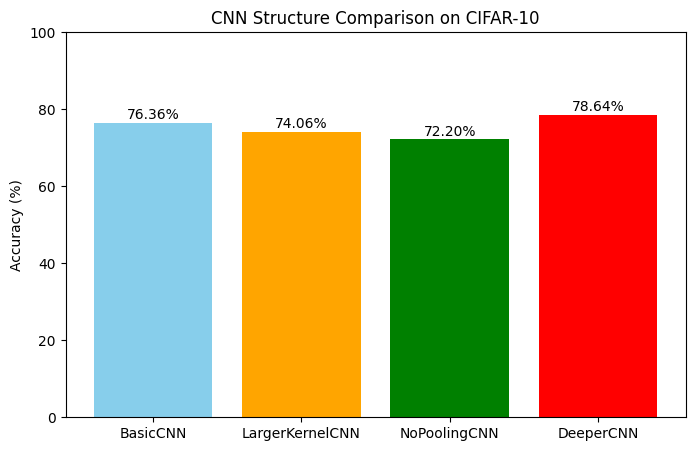

In [7]:
# =======================
# 7) 결과 시각화
# =======================
plt.figure(figsize=(8,5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("CNN Structure Comparison on CIFAR-10")
for i, acc in enumerate(results.values()):
    plt.text(i, acc+1, f"{acc:.2f}%", ha='center')
plt.show()

1. 바 그래프로 모델별 정확도 시각화